# T81-558: Applications of Deep Neural Networks
**Module 10: Time Series in PyTorch**  

* Instructor: [Jeff Heaton](https://sites.wustl.edu/jeffheaton/), McKelvey School of Engineering, [Washington University in St. Louis](https://engineering.wustl.edu/Programs/Pages/default.aspx)
* For more information visit the [class website](https://sites.wustl.edu/jeffheaton/t81-558/).

# Module 10 Material

* Part 10.1: Time Series Data Encoding for Deep Learning, PyTorch** [[Video]](https://www.youtube.com/watch?v=CZi5Avp6p1s&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN) [[Notebook]](t81_558_class_10_1_timeseries.ipynb)
* **Part 10.2: LSTM-Based Time Series with PyTorch** [[Video]](https://www.youtube.com/watch?v=hIQLy5zCgH4&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN) [[Notebook]](t81_558_class_10_2_lstm.ipynb)
* Part 10.3: Transformer-Based Time Series with PyTorch [[Video]](https://www.youtube.com/watch?v=NGzQpphf_Vc&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN) [[Notebook]](t81_558_class_10_3_transformer_timeseries.ipynb)
* Part 10.4: Seasonality and Trend [[Video]](https://www.youtube.com/watch?v=HOkxoLaUF9s&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN) [[Notebook]](t81_558_class_10_4_seasonal.ipynb)
* Part 10.5: Predicting with Meta Prophet [[Video]](https://www.youtube.com/watch?v=MzjMVsz0GyA&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN) [[Notebook]](t81_558_class_10_5_prophet.ipynb)

# Google CoLab Instructions

The following code checks that Google CoLab is and sets up the correct hardware settings for PyTorch.


In [ ]:
try:
    import google.colab
    COLAB = True
    print("Note: using Google CoLab")
except:
    print("Note: not using Google CoLab")
    COLAB = False

# Make use of a GPU or MPS (Apple) if one is available.  (see module 3.2)
import torch

device = (
    "mps"
    if getattr(torch, "has_mps", False)
    else "cuda"
    if torch.cuda.is_available()
    else "cpu"
)
print(f"Using device: {device}")

Note: using Google CoLab
Using device: cuda


<ipython-input-1-f368cc13b564>:14: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  if getattr(torch, "has_mps", False)


# Part 10.2: LSTM-Based Time Series with PyTorch

So far, the neural networks that we’ve examined have always had forward connections. Neural networks of this type always begin with an input layer connected to the first hidden layer. Each hidden layer always connects to the next hidden layer. The final hidden layer always connects to the output layer. This manner of connection is why these networks are called “feedforward.”  Recurrent neural networks are not as rigid, as backward linkages are also allowed. A recurrent connection links a neuron in a layer to either a previous layer or the neuron itself. Most recurrent neural network architectures maintain the state in the recurrent connections. Feedforward neural networks don’t keep any state.

## Understanding LSTM

Long Short Term Memory (LSTM) layers are a type of recurrent unit that you often use with deep neural networks.[[Cite:hochreiter1997long]](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.676.4320) For TensorFlow, you can think of LSTM as a layer type that you can combine with other layer types, such as dense. LSTM makes use of two transfer function types internally.  

The first type of transfer function is the sigmoid.  This transfer function type is used form gates inside of the unit.  The sigmoid transfer function is given by the following equation:

$ \mbox{S}(t) = \frac{1}{1 + e^{-t}} $

The second type of transfer function is the hyperbolic tangent (tanh) function, which allows you to scale the output of the LSTM. This functionality is similar to how we have used other transfer functions in this course.  

We provide the graphs for these functions here:

Sigmoid


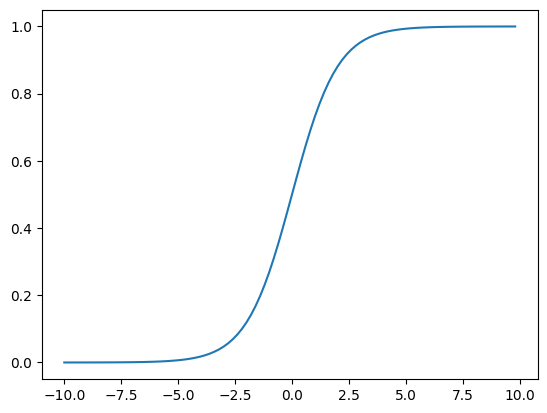

Hyperbolic Tangent(tanh)


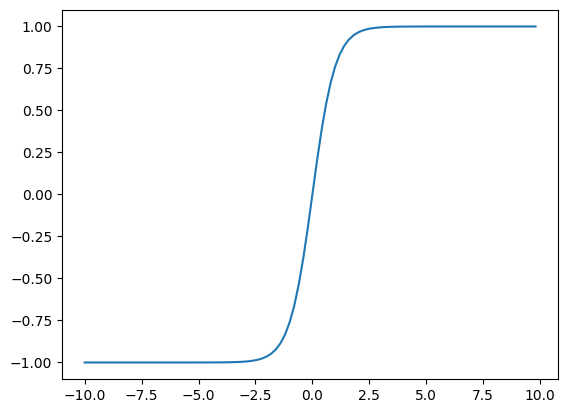

In [ ]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import math

def sigmoid(x):
    a = []
    for item in x:
        a.append(1/(1+math.exp(-item)))
    return a

def f2(x):
    a = []
    for item in x:
        a.append(math.tanh(item))
    return a

x = np.arange(-10., 10., 0.2)
y1 = sigmoid(x)
y2 = f2(x)

print("Sigmoid")
plt.plot(x,y1)
plt.show()

print("Hyperbolic Tangent(tanh)")
plt.plot(x,y2)
plt.show()

Both of these two functions compress their output to a specific range.  For the sigmoid function, this range is 0 to 1.  For the hyperbolic tangent function, this range is -1 to 1.

LSTM maintains an internal state and produces an output.  The following diagram shows an LSTM unit over three timeslices: the current time slice (t), as well as the previous (t-1) and next (t+1) slice, as demonstrated by Figure 10.LSTM.

**Figure 10.LSTM: LSTM Layers**
![LSTM Layers](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/class_10_lstm1.png "LSTM Layers")

The values $\hat{y}$ are the output from the unit; the values ($x$) are the input to the unit, and the values $c$ are the context values.  The output and context values always feed their output to the next time slice.  The context values allow the network to maintain the state between calls.  Figure 10.ILSTM shows the internals of a LSTM layer.

**Figure 10.ILSTM: Inside a LSTM Layer**
![LSTM Layers](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/class_10_lstm2.png "Inside the LSTM")

A LSTM unit consists of three gates:

* Forget Gate ($f_t$) - Controls if/when the context is forgotten. (MC)
* Input Gate ($i_t$) - Controls if/when the context should remember a value. (M+/MS)
* Output Gate ($o_t$) - Controls if/when the remembered value is allowed to pass from the unit. (RM)


## Simple LSTM Example

The following code creates the LSTM network, an example of an RNN for classification.  The following code trains on a data set (x) with a max sequence size of 6 (columns) and six training elements (rows)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# Data
max_features = 4
x_data = [
    [[0], [1], [1], [0], [0], [0]],
    [[0], [0], [0], [2], [2], [0]],
    [[0], [0], [0], [0], [3], [3]],
    [[0], [2], [2], [0], [0], [0]],
    [[0], [0], [3], [3], [0], [0]],
    [[0], [0], [0], [0], [1], [1]]
]
x = torch.tensor(x_data, dtype=torch.float32)
y = torch.tensor([1, 2, 3, 2, 3, 1], dtype=torch.int64)

# Convert labels to one-hot encoding
y2 = torch.nn.functional.one_hot(y, max_features).to(torch.float32)
print(y2)

# Model using a sequence
class LSTMLayer(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LSTMLayer, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, batch_first=True)

    def forward(self, x):
        out, _ = self.lstm(x)
        return out

model = nn.Sequential(
    LSTMLayer(input_size=1, hidden_size=128),
    nn.Dropout(p=0.2),
    nn.Flatten(),
    nn.Linear(128*6, 4),
    nn.Sigmoid()
)

# Check for GPU availability
model.to(device)
x, y2 = x.to(device), y2.to(device)

# Loss and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters())

# # Train the model
# print('Train...')
# for epoch in range(200):
#     optimizer.zero_grad()
#     outputs = model(x)
#     loss = criterion(outputs, y2)
#     loss.backward()
#     optimizer.step()
#     if (epoch + 1) % 10 == 0:
#         print(f"Epoch [{epoch + 1}/200], Loss: {loss.item():.4f}")


# # Predictions
# with torch.no_grad():
#     outputs = model(x)
#     predicted_classes = torch.argmax(outputs, 1)
#     print(f"Predicted classes: {predicted_classes.cpu().numpy()}")
#     print(f"Expected classes: {y.cpu().numpy()}")



tensor([[0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.],
        [0., 1., 0., 0.]])


We can now present a sequence directly to the model for classification.

In [ ]:
def runit(model, inp):
    inp = torch.tensor(inp, dtype=torch.float32).to(device)
    with torch.no_grad():
        outputs = model(inp)
    return torch.argmax(outputs[0]).item()

print(runit(model, [[[0], [0], [0], [0], [0], [1]]]))


0


## Sun Spots Example

This section shows an example of RNN regression to predict sunspots.  You can find the data files needed for this example at the following location.

* [Sunspot Data Files](http://www.sidc.be/silso/datafiles#total)
* [Download Daily Sunspots](http://www.sidc.be/silso/INFO/sndtotcsv.php) - 1/1/1818 to now.

We begin by loading and preparing data for the LSTM model. Next, we define a list of the column headers for a dataset. Following that, we read a CSV file from the given URL using the **pd.read_csv* function. This dataset is sunspot activity. The CSV is provided by the USA government and has certain specifications:

* It uses a semicolon (;) as a separator.
* The dataset doesn't have a header, so the header=None argument ensures pandas doesn't mistakenly take the first row as column names. Instead, the predefined names list is used as the columns' header.
* Any value of '-1' in the dataset is considered as a missing value (na_values=['-1']).
* The dataset is read without setting an index column (index_col=False), meaning the default integer index will be used.
* Once executed, this code will load the specified dataset into a pandas DataFrame named df.



In [ ]:
# Data Loading
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from torch.optim.lr_scheduler import ReduceLROnPlateau

names = ['year', 'month', 'day', 'dec_year', 'sn_value',
         'sn_error', 'obs_num', 'unused1']
df = pd.read_csv(
    "https://data.heatonresearch.com/data/t81-558/SN_d_tot_V2.0.csv",
    sep=';', header=None, names=names,
    na_values=['-1'], index_col=False)

In [ ]:
df

,year,month,day,dec_year,sn_value,sn_error,obs_num,unused1
0,1818,1,1,1818.001,-1,NaN,0,1
1,1818,1,2,1818.004,-1,NaN,0,1
2,1818,1,3,1818.007,-1,NaN,0,1
3,1818,1,4,1818.010,-1,NaN,0,1
4,1818,1,5,1818.012,-1,NaN,0,1
...,...,...,...,...,...,...,...,...
72860,2017,6,26,2017.484,21,1.1,25,0
72861,2017,6,27,2017.486,19,1.2,36,0
72862,2017,6,28,2017.489,17,1.1,22,0
72863,2017,6,29,2017.492,12,0.5,25,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72865 entries, 0 to 72864
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   year      72865 non-null  int64  
 1   month     72865 non-null  int64  
 2   day       72865 non-null  int64  
 3   dec_year  72865 non-null  float64
 4   sn_value  72865 non-null  int64  
 5   sn_error  69618 non-null  float64
 6   obs_num   72865 non-null  int64  
 7   unused1   72865 non-null  int64  
dtypes: float64(2), int64(6)
memory usage: 4.4 MB


Next we perform data preprocessing tasks for the sunspot dataset. Initially, the code identifies the last occurrence where the 'obs_num' column has a value, this is to strip off incomplete data near the beginning of the file. The **sn_value** column of the dataframe is then converted into floating-point numbers, ensuring numerical computations are consistent. After this, the dataframe is split into two parts based on the 'year' column: any data prior to the year 2000 is assigned to **df_train**, and data from the year 2000 onwards is assigned to **df_test**. Subsequently, the **sn_value** column from both the training and testing dataframes is extracted, transformed into numpy arrays, and reshaped to form 2D arrays with a single column.

This restructuring is done to meet the input requirements of PyTorch. The final segment of the code focuses on data normalization. A StandardScaler is initialized, which is a tool to standardize data to have a mean of 0 and a standard deviation of 1. This scaler is trained on the training data and then used to normalize both the training and testing data. After normalization, both datasets are flattened and converted to lists, resulting in one-dimensional lists of normalized **sn_value** data for both training and testing purposes.

In [ ]:
start_id = max(df[df['obs_num']==0].index.tolist())+1

In [ ]:
df = df[start_id:].copy()
df['sn_value'] = df['sn_value'].astype(float)

In [ ]:
df_train = df[df['year'] < 2000]
df_test = df[df['year'] >= 2000]

In [ ]:
spots_train = df_train['sn_value'].to_numpy().reshape(-1,1)

In [ ]:
spots_test = df_test['sn_value'].to_numpy().reshape(-1, 1)

In [ ]:
spots_train.shape, spots_test.shape

((55160, 1), (6391, 1))

In [ ]:
scaler = StandardScaler()
spots_train = scaler.fit_transform(spots_train).flatten().tolist()
spots_test = scaler.transform(spots_test).flatten().tolist()

In [ ]:
SEQUENCE_SIZE = 10

def to_sequences(seq_size, obs):
    x = []
    y = []
    for i in range(len(obs) - seq_size):
        window = obs[i:(i+seq_size)]
        after_window = obs[i + seq_size]
        x.append(window)
        y.append(after_window)
    return torch.tensor(x, dtype=torch.float32).view(-1,seq_size,1), torch.tensor(y, dtype=torch.float32).view(-1,1)

In [ ]:
x_train, y_train = to_sequences(SEQUENCE_SIZE, spots_train)
x_test, y_test = to_sequences(SEQUENCE_SIZE, spots_test)

In [ ]:
# Setup data loaders for batch
train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = TensorDataset(x_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=64, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(64, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.dropout(x[:,-1,:])
        x = self.fc1(x)
        x = self.fc2(x)
        return x

In [ ]:
model = LSTMModel().to(device)

In [ ]:
# Train the model
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=3, verbose=True)

epochs = 1000
early_stop_count = 0
min_val_loss = float('inf')

for epoch in range(epochs):
    model.train()
    for batch in train_loader:
        x_batch, y_batch = batch
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

    # Validation
    model.eval()
    val_losses = []
    with torch.no_grad():
        for batch in test_loader:
            x_batch, y_batch = batch
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            val_losses.append(loss.item())

    val_loss = np.mean(val_losses)
    scheduler.step(val_loss)

    if val_loss < min_val_loss:
        min_val_loss = val_loss
        early_stop_count = 0
    else:
        early_stop_count += 1

    if early_stop_count >= 5:
        print("Early stopping!")
        break
    print(f"Epoch {epoch + 1}/{epochs}, Validation Loss: {val_loss:.4f}")

Epoch 1/1000, Validation Loss: 0.0341
Epoch 2/1000, Validation Loss: 0.0362
Epoch 3/1000, Validation Loss: 0.0423
Epoch 4/1000, Validation Loss: 0.0350
Epoch 5/1000, Validation Loss: 0.0340
Epoch 6/1000, Validation Loss: 0.0337
Epoch 7/1000, Validation Loss: 0.0335
Epoch 8/1000, Validation Loss: 0.0360
Epoch 9/1000, Validation Loss: 0.0343
Epoch 10/1000, Validation Loss: 0.0344
Epoch 00011: reducing learning rate of group 0 to 5.0000e-04.
Epoch 11/1000, Validation Loss: 0.0337
Early stopping!


In [ ]:
# Evaluation
model.eval()
predictions = []
with torch.no_grad():
    for batch in test_loader:
        x_batch, y_batch = batch
        x_batch = x_batch.to(device)
        outputs = model(x_batch)
        predictions.extend(outputs.squeeze().tolist())

rmse = np.sqrt(np.mean((scaler.inverse_transform(np.array(predictions).reshape(-1, 1)) - scaler.inverse_transform(y_test.numpy().reshape(-1, 1)))**2))
print(f"Score (RMSE): {rmse:.4f}")

Score (RMSE): 14.4806


In [ ]:
!pip install -q tensorflow

In [ ]:
# https://youtu.be/tepxdcepTbY
"""
@author: Sreenivas Bhattiprolu

Code tested on Tensorflow: 2.2.0
    Keras: 2.4.3

dataset: https://finance.yahoo.com/quote/GE/history/
Also try S&P: https://finance.yahoo.com/quote/%5EGSPC/history?p=%5EGSPC
"""

import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
#from datetime import datetime

In [ ]:
#Read the csv file
df = pd.read_csv('/content/GE.csv')
print(df.head()) #7 columns, including the Date.

         Date      Open      High       Low     Close  Adj Close  Volume
0  1962-01-02  4.691347  4.769536  4.644433  4.675709   0.784582  345317
1  1962-01-03  4.652252  4.652252  4.613158  4.628796   0.776710  236606
2  1962-01-04  4.628796  4.667890  4.534969  4.574063   0.767526  294159
3  1962-01-05  4.574063  4.581882  4.378590  4.456780   0.747846  436442
4  1962-01-08  4.456780  4.456780  4.316039  4.448961   0.746534  495593


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15586 entries, 0 to 15585
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       15586 non-null  object 
 1   Open       15586 non-null  float64
 2   High       15586 non-null  float64
 3   Low        15586 non-null  float64
 4   Close      15586 non-null  float64
 5   Adj Close  15586 non-null  float64
 6   Volume     15586 non-null  int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 852.5+ KB


In [ ]:
train_dates = pd.to_datetime(df['Date'])
print(train_dates.tail(5))

15581   2023-11-24
15582   2023-11-27
15583   2023-11-28
15584   2023-11-29
15585   2023-11-30
Name: Date, dtype: datetime64[ns]


In [ ]:
list(df)

['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']

In [ ]:
cols = list(df)[1:6]
print(cols)

['Open', 'High', 'Low', 'Close', 'Adj Close']


In [ ]:
df_for_training = df[cols].astype(float)

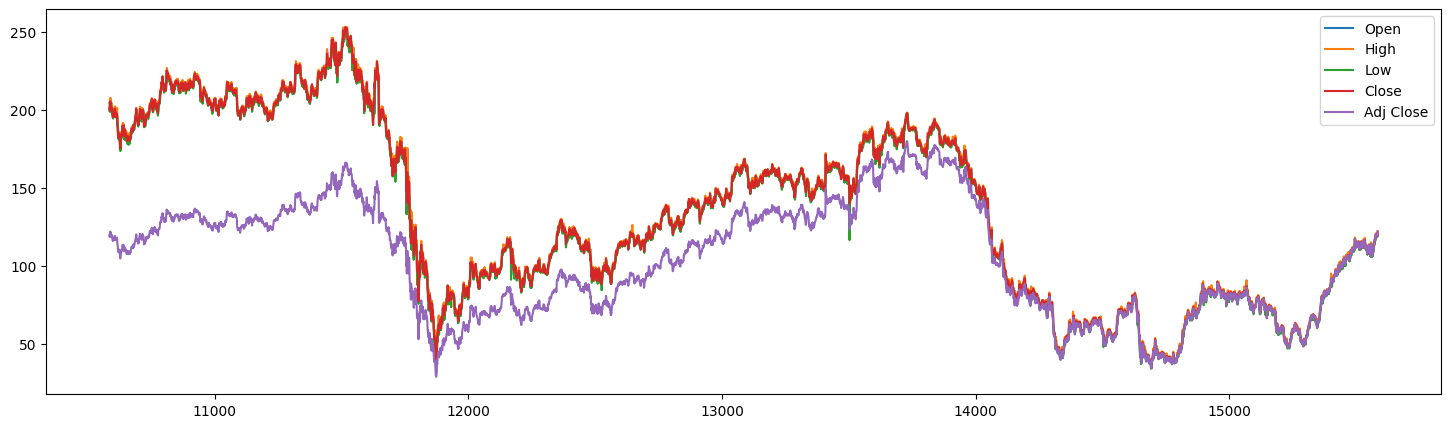

In [ ]:
df_for_plot = df_for_training.tail(5000)
df_for_plot.plot(kind='line', figsize=(18,5))
plt.show()

In [ ]:
scaler = StandardScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)

In [ ]:
trainX = []
trainY = []

In [ ]:
n_future = 1
n_past = 14

In [ ]:
df_for_training_scaled.shape

(15586, 5)

In [ ]:
for i in range(n_past, len(df_for_training_scaled)-n_future+1):
    trainX.append(df_for_training_scaled[i-n_past:i,0:df_for_training_scaled.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])

In [ ]:
np.asarray(trainX).shape, np.asarray(trainY).shape

((15572, 14, 5), (15572, 1))

In [ ]:
trainX, trainY = np.array(trainX), np.array(trainY)

In [ ]:
print('trainX shape == {}'.format(trainX.shape))
print('trainY shape == {}'.format(trainY.shape))

trainX shape == (15572, 14, 5)
trainY shape == (15572, 1)


In [ ]:
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))
model.compile(optimizer='adam', loss='mse')

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 14, 64)            17920     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 30369 (118.63 KB)
Trainable params: 30369 (118.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
history = model.fit(trainX, trainY, epochs=5, batch_size=128, validation_split=0.1, verbose=1)

Epoch 1/5
110/110 [==============================] - 11s 97ms/step - loss: 0.0288 - val_loss: 0.0032
Epoch 2/5
110/110 [==============================] - 7s 63ms/step - loss: 0.0289 - val_loss: 0.0032
Epoch 3/5
110/110 [==============================] - 7s 61ms/step - loss: 0.0273 - val_loss: 0.0030
Epoch 4/5
110/110 [==============================] - 6s 58ms/step - loss: 0.0284 - val_loss: 0.0033
Epoch 5/5
110/110 [==============================] - 7s 64ms/step - loss: 0.0283 - val_loss: 0.0061


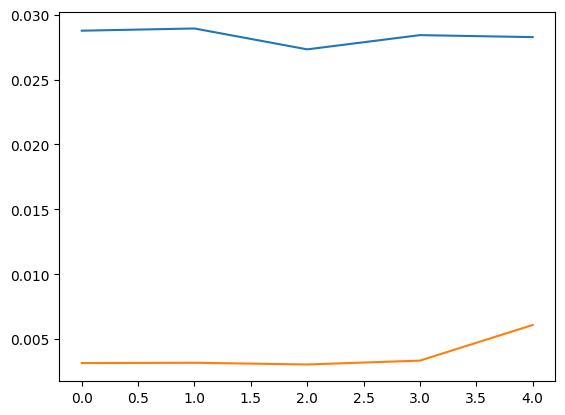

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

In [ ]:
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())

In [ ]:
n_past = 16
n_days_for_predictions = 15

In [ ]:
predict_period_dates = pd.date_range(list(train_dates)[-n_past], periods=n_days_for_predictions, freq=us_bd).to_list()

In [ ]:
print(predict_period_dates)

[Timestamp('2023-11-08 00:00:00', freq='C'), Timestamp('2023-11-09 00:00:00', freq='C'), Timestamp('2023-11-13 00:00:00', freq='C'), Timestamp('2023-11-14 00:00:00', freq='C'), Timestamp('2023-11-15 00:00:00', freq='C'), Timestamp('2023-11-16 00:00:00', freq='C'), Timestamp('2023-11-17 00:00:00', freq='C'), Timestamp('2023-11-20 00:00:00', freq='C'), Timestamp('2023-11-21 00:00:00', freq='C'), Timestamp('2023-11-22 00:00:00', freq='C'), Timestamp('2023-11-24 00:00:00', freq='C'), Timestamp('2023-11-27 00:00:00', freq='C'), Timestamp('2023-11-28 00:00:00', freq='C'), Timestamp('2023-11-29 00:00:00', freq='C'), Timestamp('2023-11-30 00:00:00', freq='C')]


In [ ]:
prediction = model.predict(trainX[-n_days_for_predictions:])

1/1 [==============================] - 0s 22ms/step


In [ ]:
prediction_copies = np.repeat(prediction, df_for_training.shape[1], axis=1)

In [ ]:
y_pred_future=scaler.inverse_transform(prediction_copies)[:,0]

In [ ]:
predict_period_dates

[Timestamp('2023-11-08 00:00:00', freq='C'),
 Timestamp('2023-11-09 00:00:00', freq='C'),
 Timestamp('2023-11-13 00:00:00', freq='C'),
 Timestamp('2023-11-14 00:00:00', freq='C'),
 Timestamp('2023-11-15 00:00:00', freq='C'),
 Timestamp('2023-11-16 00:00:00', freq='C'),
 Timestamp('2023-11-17 00:00:00', freq='C'),
 Timestamp('2023-11-20 00:00:00', freq='C'),
 Timestamp('2023-11-21 00:00:00', freq='C'),
 Timestamp('2023-11-22 00:00:00', freq='C'),
 Timestamp('2023-11-24 00:00:00', freq='C'),
 Timestamp('2023-11-27 00:00:00', freq='C'),
 Timestamp('2023-11-28 00:00:00', freq='C'),
 Timestamp('2023-11-29 00:00:00', freq='C'),
 Timestamp('2023-11-30 00:00:00', freq='C')]

In [ ]:
forecast_dates = []
for time_i in predict_period_dates:
    forecast_dates.append(time_i.date())

<ipython-input-63-6eee45713675>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original['Date']=pd.to_datetime(original['Date'])


<Axes: xlabel='Date', ylabel='Open'>

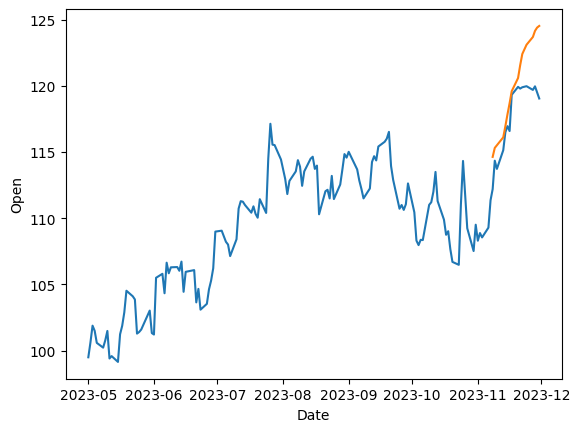

In [ ]:
df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'Open':y_pred_future})
df_forecast['Date']=pd.to_datetime(df_forecast['Date'])


original = df[['Date', 'Open']]
original['Date']=pd.to_datetime(original['Date'])
original = original.loc[original['Date'] >= '2023-5-1']

sns.lineplot(data = original, x='Date', y='Open')
sns.lineplot(data = df_forecast, x='Date', y='Open')